# Lista 5


In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.datasets import load_breast_cancer, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import loguniform

In [455]:
random_state = 222

## zad 1

**Support Vector Machine (SVM)** to algorytm klasyfikacji, który znajduje optymalną hiperpłaszczyznę maksymalizującą margines między klasami.

<center>
    <img src="./screens/l4-base.png" style="width: 90%;">
</center>

Kluczowe koncepcje z wykładu:
1. **hiperpłaszczyzna** - w $\mathbb{R}^d$ jest zdefiniowana przez: $w^T x + b = 0$, gdzie $w$ to wektor normalny, $b$ to wyraz wolny
2. **margines** - najmniejsza odległość między hiperpłaszczyzną rozdzielającą, a punktami treningowymi.
3. **wektory nośne (Support Vectors)** - punkty leżące na granicy marginesu. To one definiują optymalną hiperpłaszczyznę

Intuicja działania: szukamy hiperpłaszczyzny, która:
1. maksymalizuje margines
2. minimalizuje ryzyko błędnej

Czyli cel SVM to znalezienie $w$ i $b$ takich, że margines jest maksymalny.

<center>
    <img src="./screens/l4-optimize.png" style="width: 60%;">
</center>

Problem optymalizacji (z wykładu):

$$
\min_{w,b} \frac{1}{2}||w||^2
$$

przy ograniczeniu:

$$
y_i(w^T x_i + b) \geq 1, \quad \forall i
$$

<center>
    <img src="./screens/l4-how-it-works.gif" style="width: 60%;"><br>
    <small>source: <a href="https://medium.com/@riyaraut/simplest-explaination-on-support-vector-machine-svm-1b435f4d1401">https://medium.com/@riyaraut/simplest-explaination-on-support-vector-machine-svm-1b435f4d1401</a></small>
</center>

Generuje prosty dataset

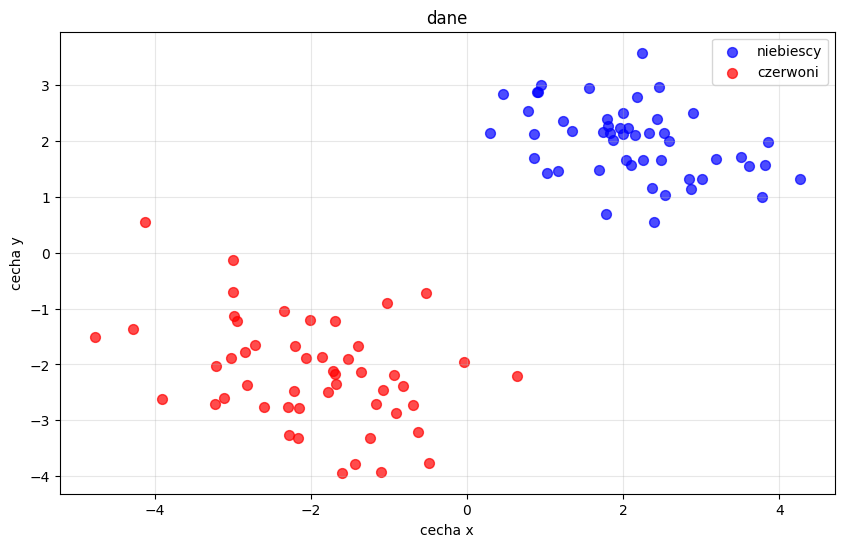

In [456]:
np.random.seed(random_state)
X_simple, y_simple = make_classification(
    n_samples=100,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=random_state
)
y_simple = np.where(y_simple == 0, -1, 1)

plt.figure(figsize=(10, 6))
plt.scatter(X_simple[y_simple == 1, 0], X_simple[y_simple == 1, 1], color='blue', label='niebiescy', s=50, alpha=0.7)
plt.scatter(X_simple[y_simple == -1, 0], X_simple[y_simple == -1, 1], color='red', label='czerwoni', s=50, alpha=0.7)
plt.xlabel('cecha x')
plt.ylabel('cecha y')
plt.title('dane')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Zaimplementuję prosty SVM od podstaw używając podejścia gradientowego.

<center>
    <img src="./screens/l4-implementation-1.png" style="width: 40%; margin-right: 5%;">
    <img src="./screens/l4-implementation-2.png" style="width: 40%;">
    <br><br>
    <img src="./screens/l4-kernel.png" style="width: 40%;">
</center>

In [457]:
class SimpleSVM:
    def __init__(self, C=1.0, max_iters=10000):
        self.C = C
        self.max_iters = max_iters

    def fit(self, X, y):
        n = len(X)
        self.alphas = np.zeros(n)
        self.b = 0

        # K(xi, xj) na wykładzie są różne możliwości tego
        K = X @ X.T

        for _ in range(self.max_iters):

            # wybór pary (alfa i, alfa j) losowo bo prościej niż "heurystyki wyboru: punkty naruszające warunki KKT"
            i, j = np.random.choice(n, 2, replace=False)

            # f(xi) - czyli predykcja
            f_i = np.sum(self.alphas * y * K[:, i]) + self.b
            f_j = np.sum(self.alphas * y * K[:, j]) + self.b

            # Ei - bład predykcji
            Ei = f_i - y[i]
            Ej = f_j - y[j]

            alpha_i_old = self.alphas[i]
            alpha_j_old = self.alphas[j]

            # przedział ograniczeń [L, H] wynikający z 0 <= alfa i, alfa j <= C (slajd prawo góra)
            if y[i] != y[j]:
                L = max(0, alpha_j_old - alpha_i_old)
                H = min(self.C, self.C + alpha_j_old - alpha_i_old)
            else:
                L = max(0, alpha_i_old + alpha_j_old - self.C)
                H = min(self.C, alpha_i_old + alpha_j_old)

            if L == H:
                continue

            # η = slajd prawo góra
            eta = 2*K[i, j] - K[i, i] - K[j, j]
            if eta >= 0:
                continue

            aj = alpha_j_old - y[j]*(Ei - Ej)/eta
            aj = np.clip(aj, L, H)

            ai = alpha_i_old + y[i]*y[j]*(alpha_j_old - aj)

            self.alphas[i] = ai
            self.alphas[j] = aj

            # bez tego nie działa, ale brak info na wykładzie. support chat gpt
            b1 = self.b - Ei - y[i]*(ai - alpha_i_old)*K[i, i] - y[j]*(aj - alpha_j_old)*K[i, j]
            b2 = self.b - Ej - y[i]*(ai - alpha_i_old)*K[i, j] - y[j]*(aj - alpha_j_old)*K[j, j]
            self.b = 0.5*(b1 + b2)

        # dla liniowego jądra: w = suma αi yi xi
        self.w = np.sum((self.alphas * y).reshape(-1, 1) * X, axis=0)

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

    def decision_function(self, X):
        return X @ self.w + self.b

Po trudzie implementacji pora na użycie

In [458]:
svm_simple = SimpleSVM(C=1)
svm_simple.fit(X_simple, y_simple)
svm_simple.w = np.array(list(map(lambda x: round(x, 2), svm_simple.w)))

y_pred_simple = svm_simple.predict(X_simple)
accuracy_simple = np.mean(y_pred_simple == y_simple)

print(f"Dokładność własnej implementacji SVM: {accuracy_simple:.4f}")
print(f"Współczynniki w: {svm_simple.w}")
print(f"Wyraz wolny b: {svm_simple.b:.2f}")


Dokładność własnej implementacji SVM: 1.0000
Współczynniki w: [0.53 0.55]
Wyraz wolny b: 0.05


Wizualizacja hiperpłaszczyzny i marginesu (podobnie jak na wykładzie)


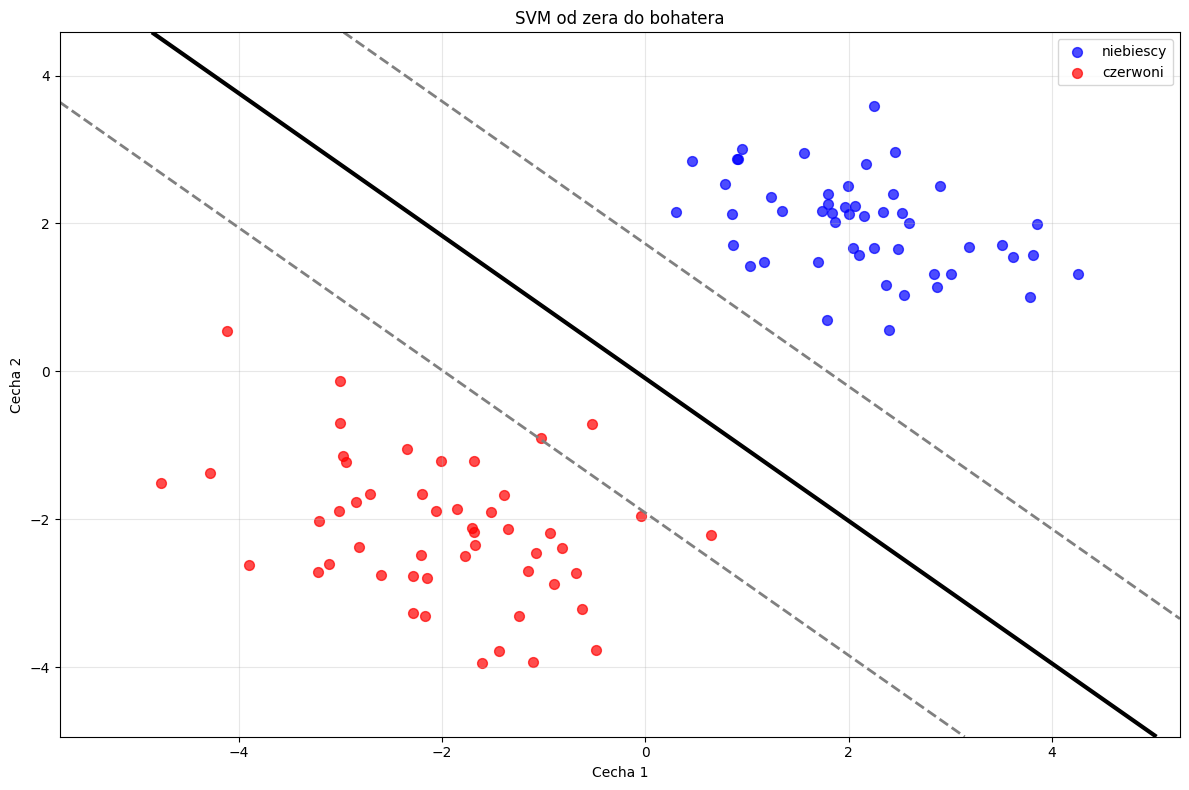

In [459]:
def plot_svm_decision_boundary(X, y, model, title="SVM Decision Boundary"):
    plt.figure(figsize=(12, 8))
    
    # to z wykładu
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['gray', 'black', 'gray'], linestyles=['--', '-', '--'], linewidths=[2, 3, 2])
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='niebiescy', s=50, alpha=0.7)
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='red', label='czerwoni', s=50, alpha=0.7)
    
    plt.xlabel('Cecha 1')
    plt.ylabel('Cecha 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_svm_decision_boundary(X_simple, y_simple, svm_simple, "SVM od zera do bohatera")

## zad 2

Teraz wykorzystam gotową implementację SVM z biblioteki `scikit-learn` na rzeczywistym zbiorze danych **Breast Cancer**. Ten zbiór zawiera cechy komórek nowotworowych i klasyfikację jako złośliwy (malignant) lub łagodny (benign).


In [460]:
breast_cancer = load_breast_cancer()
X_cancer = breast_cancer.data
y_cancer = breast_cancer.target

print(f"Liczba próbek: {X_cancer.shape[0]}")
print(f"Liczba cech: {X_cancer.shape[1]}")
print(f"Klasa 0 (złośliwy): {(y_cancer == 0).sum()} próbek")
print(f"Klasa 1 (łagodny): {(y_cancer == 1).sum()} próbek")

Liczba próbek: 569
Liczba cech: 30
Klasa 0 (złośliwy): 212 próbek
Klasa 1 (łagodny): 357 próbek


In [461]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.4, random_state=random_state, stratify=y_cancer)

**Ważne (z wykładu):** SVM jest wrażliwe na skalę danych - wymaga standaryzacji (mean=0, std=1).


In [462]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [463]:
svm_linear = SVC(kernel='linear', random_state=random_state)
svm_linear.fit(X_train_scaled, y_train)

y_train_pred = svm_linear.predict(X_train_scaled)
y_test_pred = svm_linear.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Dokładność na zbiorze treningowym: {train_acc:.4f}")
print(f"Dokładność na zbiorze testowym: {test_acc:.4f}")


Dokładność na zbiorze treningowym: 0.9883
Dokładność na zbiorze testowym: 0.9649


macierz pomyłek

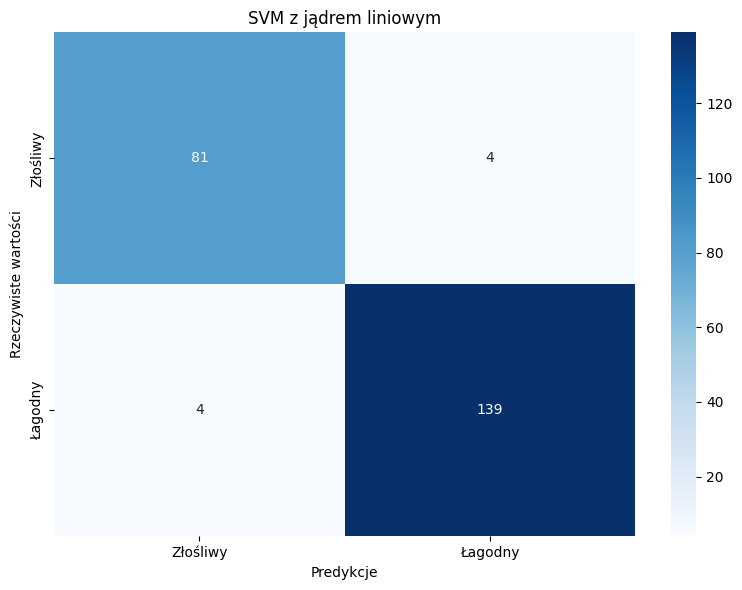

In [464]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Złośliwy', 'Łagodny'], yticklabels=['Złośliwy', 'Łagodny'])
plt.ylabel('Rzeczywiste wartości')
plt.xlabel('Predykcje')
plt.title('SVM z jądrem liniowym')
plt.tight_layout()
plt.show()


In [465]:
print("Raport klasyfikacji:")
print(classification_report(y_test, y_test_pred, target_names=['Złośliwy', 'Łagodny']))

Raport klasyfikacji:
              precision    recall  f1-score   support

    Złośliwy       0.95      0.95      0.95        85
     Łagodny       0.97      0.97      0.97       143

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228



## zad 3

**Metoda jądra** to technika pozwalająca SVM radzić sobie z danymi nieliniowo separowalnymi poprzez niejawne odwzorowanie danych do przestrzeni o większej liczbie wymiarów.

<center>
    <img src="./screens/l4-kernel-trick.png" style="width: 40%; margin-right: 5%;">
    <img src="./screens/l4-kernel-list.png" style="width: 40%;">
</center>

Najpierw generuje syntetyczne dane

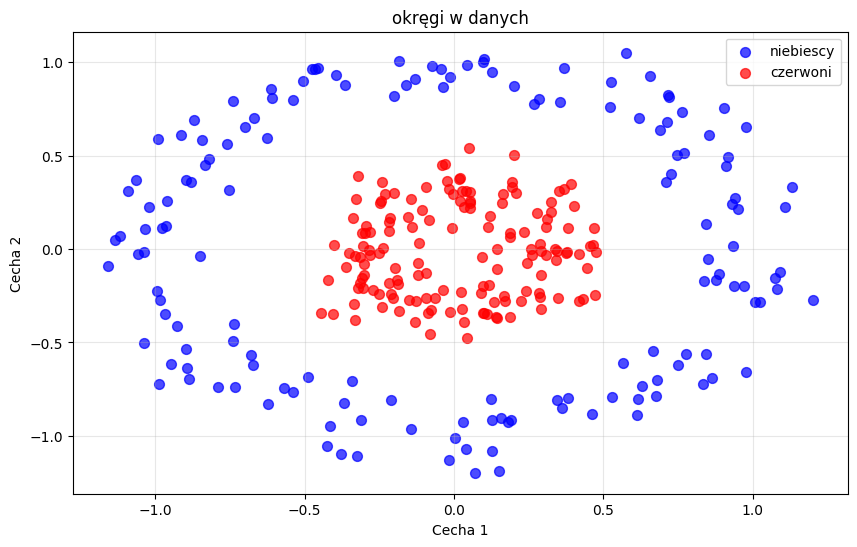

In [466]:
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=random_state)

plt.figure(figsize=(10, 6))
plt.scatter(X_circles[y_circles == 0, 0], X_circles[y_circles == 0, 1], color='blue', label='niebiescy', s=50, alpha=0.7)
plt.scatter(X_circles[y_circles == 1, 0], X_circles[y_circles == 1, 1], color='red', label='czerwoni', s=50, alpha=0.7)
plt.xlabel('Cecha 1')
plt.ylabel('Cecha 2')
plt.title('okręgi w danych')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Dziele dane na zbiór treningowy i testowy

In [467]:
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(
    X_circles, y_circles, test_size=0.2, random_state=random_state
)

Trenuję dwa modele SVM: jeden z jądrem liniowym,

In [468]:
svm_linear_circles = SVC(kernel='linear', random_state=random_state)
svm_linear_circles.fit(X_circles_train, y_circles_train)
y_pred_linear = svm_linear_circles.predict(X_circles_test)
acc_linear = accuracy_score(y_circles_test, y_pred_linear)

drugi z jądrem RBF

In [469]:
svm_rbf_circles = SVC(kernel='rbf', random_state=random_state)
svm_rbf_circles.fit(X_circles_train, y_circles_train)
y_pred_rbf = svm_rbf_circles.predict(X_circles_test)
acc_rbf = accuracy_score(y_circles_test, y_pred_rbf)

Podsumowanie:

In [470]:
print(f"Dokładność SVM z jądrem liniowym: {acc_linear:.4f}")
print(f"Dokładność SVM z jądrem RBF: {acc_rbf:.4f}")

Dokładność SVM z jądrem liniowym: 0.4333
Dokładność SVM z jądrem RBF: 1.0000


In [471]:
def plot_decision_boundary_sklearn(X, y, model, title="SVM Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='niebiescy', s=50, edgecolors='k')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='czerwoni', s=50, edgecolors='k')
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=200, linewidth=2, facecolors='none', edgecolors='green')
    plt.xlabel('cecha 1')
    plt.ylabel('cecha 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)


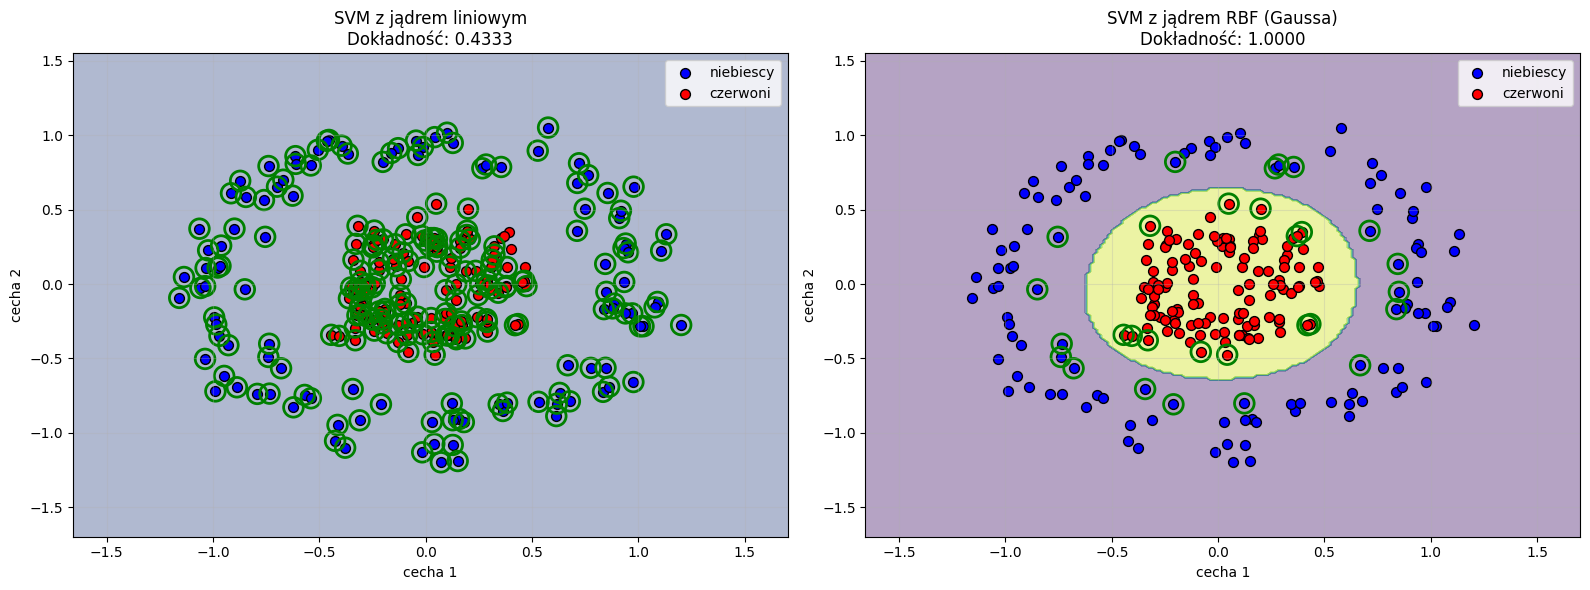

In [472]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_decision_boundary_sklearn(X_circles_train, y_circles_train, svm_linear_circles, f"SVM z jądrem liniowym\nDokładność: {acc_linear:.4f}")

plt.subplot(1, 2, 2)
plot_decision_boundary_sklearn(X_circles_train, y_circles_train, svm_rbf_circles, f"SVM z jądrem RBF (Gaussa)\nDokładność: {acc_rbf:.4f}")

plt.tight_layout()
plt.show()


Wnioski:
- jądro liniowe nie może poprawnie rozdzielić koncentrycznych okręgów, przypisuje wszystko do jednej kat.
- jądro RBF tworzy nieliniową granicę decyzyjną dzięki kernel trick. Odwzorowuje dane do przestrzeni o większej liczbie wymiarów


## zad 4

Kluczowe hiperparametry:

1. **C (parametr regularyzacji)**:
<center>
    <img src="./screens/l4-c-hiperparametr.png" style="width: 80%;">
</center>

2. **gamma (dla jądra RBF)**: kontroluje zasięg

<center>
    <img src="./screens/l4-gamma-hiperparametr.png" style="width: 80%;">
</center>

In [492]:
param_grid = {
    'C': [0.1, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7, 10, 11, 50, 100, 100],
    'gamma': ['scale', 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 1]
}

print(f"kombinacje do przeszukania: {len(param_grid['C']) * len(param_grid['gamma'])}")

kombinacje do przeszukania: 135


Używam `GridSerachCV`

In [493]:
svm_rbf = SVC(kernel='rbf', random_state=random_state)
grid_search = GridSearchCV(
    svm_rbf, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train)
grid_time = time.time() - start_time

print(f"Czas przeszukania siatki: {grid_time:.2f} sekund")
print(f"Najlepsze parametry: {grid_search.best_params_}")
print(f"Najlepsza dokładność (CV): {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Czas przeszukania siatki: 0.19 sekund
Najlepsze parametry: {'C': 1, 'gamma': 0.02}
Najlepsza dokładność (CV): 0.9824


teraz na test sprawdzam

In [494]:
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
test_acc_best = accuracy_score(y_test, y_pred_best)

print(f"dokładność: {test_acc_best:.4f}")

dokładność: 0.9649


Porównanie z modelem o domyślnych parametrach


In [497]:
svm_default = SVC(kernel='rbf', random_state=random_state)
svm_default.fit(X_train_scaled, y_train)
y_pred_default = svm_default.predict(X_test_scaled)
test_acc_default = accuracy_score(y_test, y_pred_default)

comparison_df = pd.DataFrame({
    'Model': ['Domyślne parametry', 'Po optymalizacji (GridSearchCV)'],
    'C': [1.0, grid_search.best_params_['C']],
    'gamma': [1 / (X_train_scaled.shape[1] * X_train_scaled.var()), grid_search.best_params_['gamma']], # gamma = scale = 1 / (n_features * X.var())
    'dokładność testowa': [test_acc_default, test_acc_best]
})

comparison_df


,Model,C,gamma,dokładność testowa
0,Domyślne parametry,1.0,0.033333,0.969298
1,Po optymalizacji (GridSearchCV),1.0,0.020000,0.964912


Zwizualizuje proces przeszukiwań


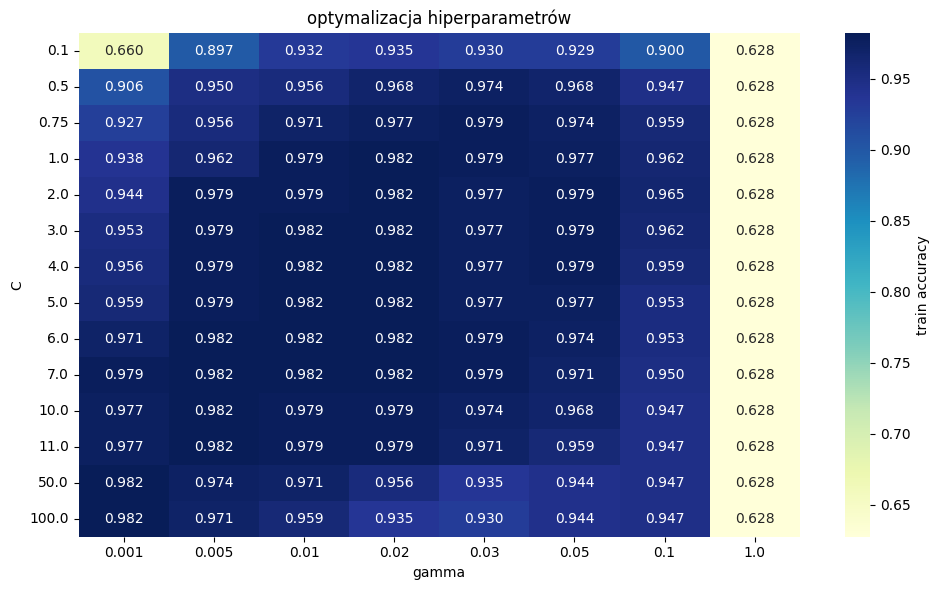

In [503]:
results_df = pd.DataFrame(grid_search.cv_results_)
numeric_results = results_df[results_df['param_gamma'].apply(lambda x: isinstance(x, (int, float)))].copy()

if len(numeric_results) > 0:
    pivot = numeric_results.pivot_table(
        values='mean_test_score',
        index='param_C',
        columns='param_gamma',
        aggfunc='first'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', cbar_kws={'label': 'train accuracy'})
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.title('optymalizacja hiperparametrów')
    plt.tight_layout()
    plt.show()
else:
    print("Brak numerycznych wartości gamma do wizualizacji")


## zad 5

XGBoost i LightGBM to nowoczesne implementacje gradient boosting. Zgodnie z wykładem, warto porównać różne metody klasyfikacji pod kątem:
- czasu trenowania,
- dokładności,
- szybkości predykcji.

<center>
    <img src="./screens/l4-rozne-metody.png" style="width: 80%;">
</center>

Porównam XGBoost i LightGBM na zbiorze Breast Cancer. Zaczynam  od XGBoost

In [506]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=random_state,
    eval_metric='logloss'
)

start_time = time.time()
xgb_model.fit(X_train_scaled, y_train)
xgb_train_time = time.time() - start_time

start_time = time.time()
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_pred_time = time.time() - start_time

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost:")
print(f"- czas trenowania: {xgb_train_time:.2f} s")
print(f"- czas predykcji: {xgb_pred_time:.4f} s")
print(f"- dokładność: {xgb_accuracy:.2f}")

XGBoost:
- czas trenowania: 0.09 s
- czas predykcji: 0.0006 s
- dokładność: 0.96


teraz LightGBM

In [507]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=random_state,
    verbose=-1
)

start_time = time.time()
lgb_model.fit(X_train_scaled, y_train)
lgb_train_time = time.time() - start_time

start_time = time.time()
y_pred_lgb = lgb_model.predict(X_test_scaled)
lgb_pred_time = time.time() - start_time

lgb_accuracy = accuracy_score(y_test, y_pred_lgb)

print(f"LightGBM:")
print(f"- czas trenowania: {lgb_train_time:.2f} s")
print(f"- czas predykcji: {lgb_pred_time:.4f} s")
print(f"- dokładność: {lgb_accuracy:.2f}")


LightGBM:
- czas trenowania: 0.03 s
- czas predykcji: 0.0013 s
- dokładność: 0.97


/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Podsumowanie:

In [508]:
# Comparison table
comparison_boosting = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'Czas trenowania [s]': [xgb_train_time, lgb_train_time],
    'Czas predykcji [s]': [xgb_pred_time, lgb_pred_time],
    'Dokładność': [xgb_accuracy, lgb_accuracy]
})

comparison_boosting


,Model,Czas trenowania [s],Czas predykcji [s],Dokładność
0,XGBoost,0.092306,0.000567,0.956140
1,LightGBM,0.025644,0.001253,0.973684


Analiza wpływu liczby estymatorów na czas i dokładność


/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/

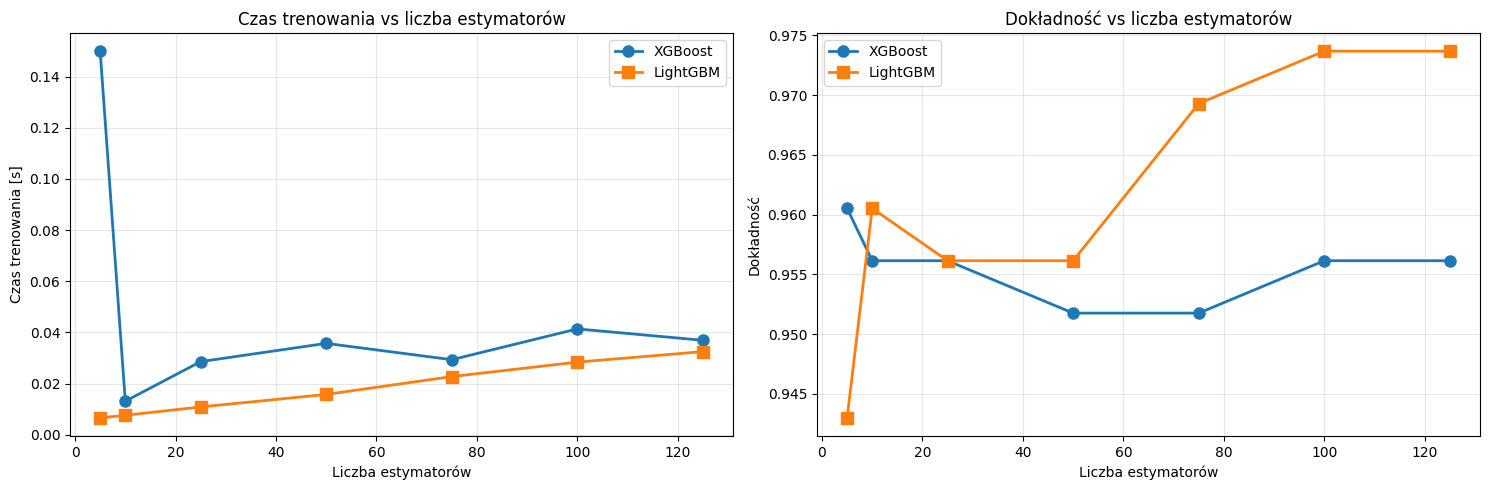

In [510]:
n_estimators_list = [5, 10, 25, 50, 75, 100, 125]

xgb_times = []
lgb_times = []
xgb_accs = []
lgb_accs = []

for n_est in n_estimators_list:
    # XGBoost
    xgb_temp = xgb.XGBClassifier(n_estimators=n_est, random_state=random_state, eval_metric='logloss')
    start = time.time()
    xgb_temp.fit(X_train_scaled, y_train)
    xgb_times.append(time.time() - start)
    xgb_accs.append(accuracy_score(y_test, xgb_temp.predict(X_test_scaled)))
    
    # LightGBM
    lgb_temp = lgb.LGBMClassifier(n_estimators=n_est, random_state=random_state, verbose=-1)
    start = time.time()
    lgb_temp.fit(X_train_scaled, y_train)
    lgb_times.append(time.time() - start)
    lgb_accs.append(accuracy_score(y_test, lgb_temp.predict(X_test_scaled)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(n_estimators_list, xgb_times, 'o-', label='XGBoost', linewidth=2, markersize=8)
ax1.plot(n_estimators_list, lgb_times, 's-', label='LightGBM', linewidth=2, markersize=8)
ax1.set_xlabel('Liczba estymatorów')
ax1.set_ylabel('Czas trenowania [s]')
ax1.set_title('Czas trenowania vs liczba estymatorów')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(n_estimators_list, xgb_accs, 'o-', label='XGBoost', linewidth=2, markersize=8)
ax2.plot(n_estimators_list, lgb_accs, 's-', label='LightGBM', linewidth=2, markersize=8)
ax2.set_xlabel('Liczba estymatorów')
ax2.set_ylabel('Dokładność')
ax2.set_title('Dokładność vs liczba estymatorów')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Wnioski:
- **LightGBM** jest zazwyczaj szybszy od XGBoost o mniej niż mrugnięcie
- Oba osiągają wysoką dokładność

## zad 6

walidacja krzyżowa (Cross-Validation) zaleca sie do:
- doboru hiperparametrów
- rzetelnej oceny wydajności modelu

**zalety:**
- lepsze wykorzystanie danych
- bardziej stabilna ocena niż jednorazowy podział
- oszacowanie wariancji wyniku

**rodzaje:**
- **KFold**: k równych części
- **StratifiedKFold**: zachowuje proporcje klas (lepsze dla niezbalansowanych danych)

<center>
    <img src="./screens/l4-cross.png" style="width: 80%;"><br>
    <small>source: <a href="https://towardsdatascience.com/how-to-cross-validation-with-time-series-data-9802a06272c6/">https://towardsdatascience.com/how-to-cross-validation-with-time-series-data-9802a06272c6/</a></small>
</center>

Przeprowadzę walidację krzyżową dla XGBoost

In [514]:
xgb_cv = xgb.XGBClassifier(
    n_estimators=100,
    random_state=random_state,
    eval_metric='logloss'
)

# X_cancer, y_cancer

Z `KFold`

In [517]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_model)
])

kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
kfold_scores = cross_val_score(pipeline, X_cancer, y_cancer, cv=kfold, scoring='accuracy')

print(f"wyniki dla każdego foldu: {[f'{score:.4f}' for score in kfold_scores]}")
print(f"średnia dokładność: {kfold_scores.mean():.4f}")
print(f"odchylenie standardowe: {kfold_scores.std():.4f}")

wyniki dla każdego foldu: ['0.9649', '0.9825', '0.9737', '0.9474', '0.9646']
średnia dokładność: 0.9666
odchylenie standardowe: 0.0116


i `SratifiedKFold`

In [518]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
stratified_scores = cross_val_score(pipeline, X_cancer, y_cancer, cv=stratified_kfold, scoring='accuracy')

print(f"wyniki dla każdego foldu: {[f'{score:.4f}' for score in stratified_scores]}")
print(f"średnia dokładność: {stratified_scores.mean():.4f}")
print(f"odchylenie standardowe: {stratified_scores.std():.4f}")

wyniki dla każdego foldu: ['0.9561', '0.9825', '0.9825', '0.9474', '0.9823']
średnia dokładność: 0.9701
odchylenie standardowe: 0.0153


Podsumowanie

/tmp/ipykernel_84729/2322173249.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(data_to_plot, labels=['KFold', 'StratifiedKFold'], patch_artist=True)


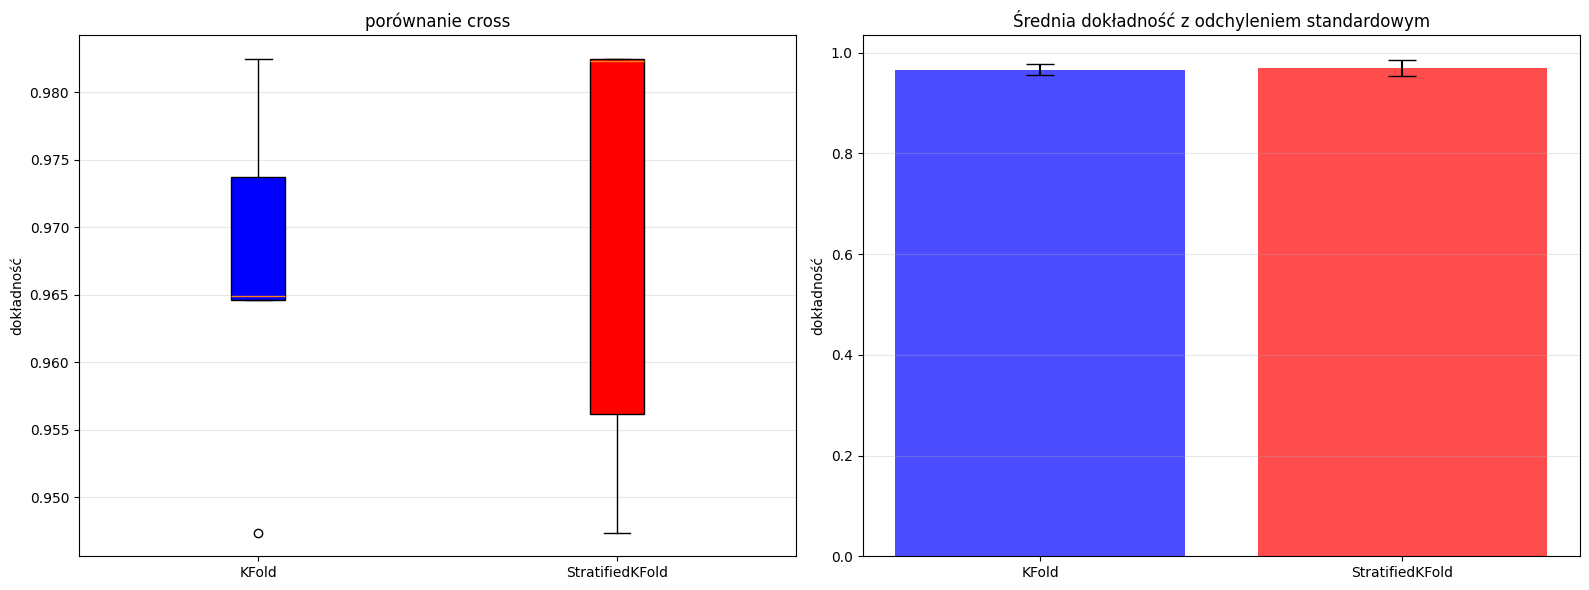

In [522]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

data_to_plot = [kfold_scores, stratified_scores]

bp = ax1.boxplot(data_to_plot, labels=['KFold', 'StratifiedKFold'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['blue', 'red']):
    patch.set_facecolor(color)

ax1.set_ylabel('dokładność')
ax1.set_title('porównanie cross')
ax1.grid(True, alpha=0.3, axis='y')

methods = ['KFold', 'StratifiedKFold']
means = [kfold_scores.mean(), stratified_scores.mean()]
stds = [kfold_scores.std(), stratified_scores.std()]

x_pos = np.arange(len(methods))
ax2.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7, color=['blue', 'red'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods)
ax2.set_ylabel('dokładność')
ax2.set_title('Średnia dokładność z odchyleniem standardowym')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Test dla różnej liczby foldów


In [523]:
k_values = [3, 5, 7, 10]
cv_results = []

for k in k_values:
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    scores = cross_val_score(xgb_cv, X_cancer_scaled, y_cancer, cv=cv, scoring='accuracy')
    
    cv_results.append({
        'k': k,
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max()
    })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df

,k,mean,std,min,max
0,3,0.970138,0.012379,0.952632,0.978947
1,5,0.970144,0.015270,0.947368,0.982456
2,7,0.964899,0.016588,0.938272,0.987654
3,10,0.964912,0.033287,0.894737,1.000000


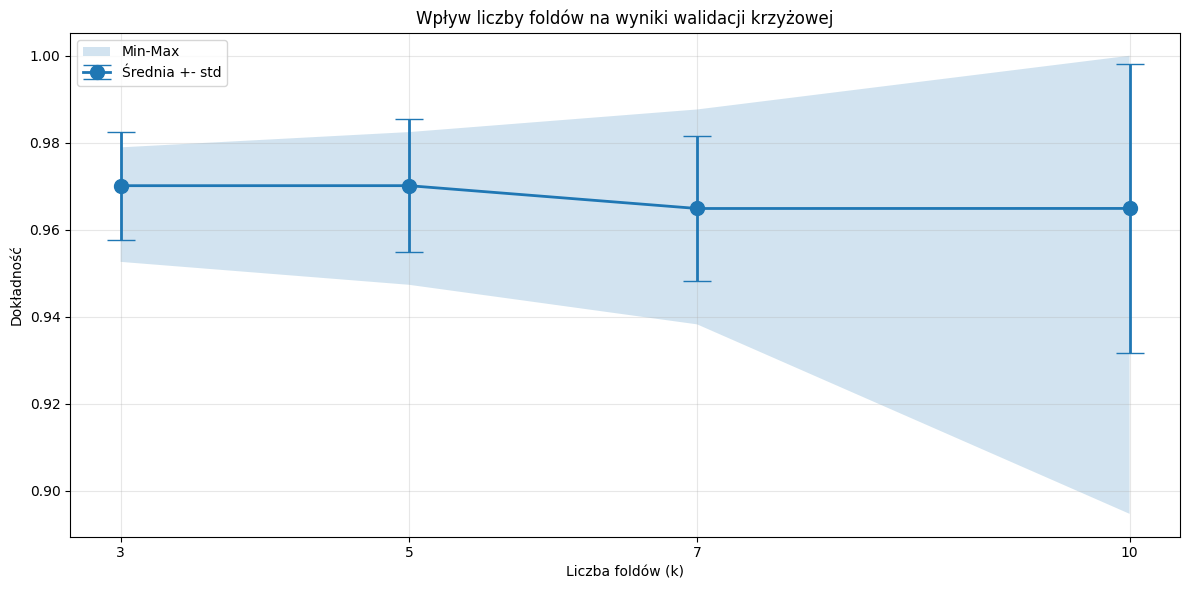

In [524]:
plt.figure(figsize=(12, 6))
plt.errorbar(cv_results_df['k'], cv_results_df['mean'], yerr=cv_results_df['std'], marker='o', markersize=10, capsize=10, linewidth=2, label='Średnia +- std')
plt.fill_between(cv_results_df['k'], cv_results_df['min'], cv_results_df['max'], alpha=0.2, label='Min-Max')
plt.xlabel('Liczba foldów (k)')
plt.ylabel('Dokładność')
plt.title('Wpływ liczby foldów na wyniki walidacji krzyżowej')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.tight_layout()
plt.show()